In [8]:
import random
from math import ceil
random.seed()

#partitions lst
#so that for a in partition[i] and b in partition[j]
#i < j ==> a < b
#gensizes is a function that takes a list 
#and returns a list of partition sizes
def partition(lst,gensizes):

    #create partition sizes
    part_sizes = gensizes(lst)
    
    #create and fill partitions array
    items_left = lst
    partitions = []
    for i in part_sizes:
        partitions.append(items_left[0:i])
        items_left = items_left[i:]
    
    return partitions

#randPart randomly partitions the list lst into
#at least 2 partitions
def randPart(lst):
    return partition(lst,genRandPartSizes)

#genRandPartSizes returns a random list part_sizes, [p1,p2,...,pn]
#so that len(partsizes) > 1 and
#p1 + p2 + ...+ pn = len(lst)
def genRandPartSizes(lst):
    #random.seed(1)
    #generate partition sizes
    n = len(lst)
    part_sizes = []
    while n > 1:
        ps = random.randint(1,n-1)
        part_sizes.append(ps)
        n -=ps
    
    #append the size of the last partition if non-zero
    if n > 0:
        part_sizes.append(n)
    
    return part_sizes


def randBinPart(lst):
    n = random.randint(1,len(lst)-1)
    return partition(lst,lambda x: [n,len(lst)-n])

In [7]:
#functions to perform tree rotations
def rotateLeft(subtree):
    return [[subtree[0],subtree[1][0]],subtree[1][1]] 

def rotateRight(subtree):
    return [subtree[0][0],[subtree[0][1],subtree[1]]]

#we would like to perform random rotations
#randRotate returns a pair [action,rotated subtree]
def randRotate(subtree):
    #0 - do nothing, 1 - rotate left, 2 - rotate right
    action = random.randint(0,2) 
    if  action == 1:
        #rotate right
        #check we can rotate right
        if isinstance(subtree[0],list):
            return [1,[subtree[0][0],[subtree[0][1],subtree[1]]]]
        else:
            return [0,subtree]
    elif action == 2:
        #rotate left
        if isinstance(subtree[1],list):
            return [2,[[subtree[0],subtree[1][0]],subtree[1][1]]]
        else:
            return [0,subtree]
    else:
        return [0,subtree]

In [3]:
#generates a random tree containing the leaves in the "leaves" list 
#Base case: for input [leaf] ==> leaf whch is the only posible tree
#Induction: ranPart yields partitions smaller than n+1
#it will produce the tree [genRandTree(p1),...,genRandTree(pn)]
#which works by IHOP
#Halting: calling randPart will yield partitions of smaller size
#eventually reachin the base case
def genRandTree(leaves):
    if len(leaves) < 2:
        return leaves[0]
    
    subtree=[]
    for part in randPart(leaves):
        subtree.append(genRandTree(part))
    
    return subtree

In [6]:
#generates a binary tree
def genRandBinTree(leaves):
    if len(leaves) < 2:
        return leaves[0]
    
    subtree=[]
    for part in randBinPart(leaves):
        subtree.append(genRandBinTree(part))
    
    return subtree

In [5]:
#generates a random binary tree in Newick format
def randNewickBinSubTree(leaves):
    if len(leaves) < 2:
        return str(leaves[0]) + ":1"
    
    subtree="("
    for part in randBinPart(leaves):
        subtree += randNewickBinSubTree(part) + ","
    
    return subtree[0:-1] + "):1"

def randNewickBinTree(leaves):
    
    if len(leaves) < 2:
        return "(" + str(leaves[0]) + ":1" + ")"
    
    tree ="("
    for part in randBinPart(leaves):
        tree += randNewickBinSubTree(part) + ","
        
    return tree[0:-1] + ")"

In [30]:
#convert tree to Newick format
def toNewickSubTree(tree):
    
    #case leaf reached
    if not isinstance(tree,list):
        return str(tree) + ":1"
    
    ntree = "("
    for subtree in tree:
        ntree += toNewickSubTree(subtree) + ","
    
    return ntree[0:-1] + "):1"

def toNewickTree(tree):
    ntree = "("
    for subtree in tree:
        ntree += toNewickSubTree(subtree) + ","
    return ntree[0:-1] + ")"

In [33]:
#write trees to text file
#with open('randtrees','w') as file:
#    for i in range(0,10):
#        file.write(randNewickBinTree(range(0,10)) + "\n")

In [25]:
#TODO
#1 - generate random trees by performing random rotations
#2 - read GTP output file
#5 - run GTP on the tree sequence file and and get file with
#    tree distance and the geodesic

In [11]:
#create count nodes
def countNodes(tree):
    if not isinstance(tree,list):
        return 0
    
    return 1 + countNodes(tree[0]) + countNodes(tree[1])

In [9]:
#perform random SPR move
#PRE: tree is a nested list representation of a tree
#POST: returns a new tree with a random SPR move
#      the resulting tree will have same number of nodes as the
#      initial tree
__prunedbranch__ = []
def randSPR(tree,total_nodes):
    global __prunedbranch__
    targetNode = random.randint(1,total_nodes)
    pruned,n = __prune__(tree,targetNode,0)
    
    if not isinstance(pruned,list):#if the pruned tree is a leaf return the original tree
        return (tree,0) 
    
    targetNode = random.randint(1,total_nodes - countNodes(__prunedbranch__) - 1)
    return __regraft__(pruned,targetNode,0)


#POST: return a pair of the form (pruned tree, number of visited nodes) and the
#      variable __prunedbranch__ contains the subtree removed from tree

#Base Cases:
#two kinds of base cases
# 1 cases where no visited node is counted
# like (leaf) or (number of visited nodes== targetNode)
#in this case it returns the tree unmodified and the
#number of visited nodes is not incremented

# 2 occurs when targetNode is visited
# saves and removes the pruned branch from the node
#other branch is returned so the tree remains complete
#and we count this node as visited

#the base cases work as we would want

#Assume __prune__ works for subtree with 1..k nodes
#for a tree having k+1 nodes
#__prune__(tree[0],targetNode,visited_nodes + 1)
#will return the properly pruned left subtree and the correct number of visited nodes
#so __prune__(tree[1],targetNode,visited_nodes1)
#will return the properly pruned right subtree and the correct total of visited nodes
#then [subtree1,subtree2] will be a properly pruned tree and 
#visuted_nodes2 will be the total number of visited nodes
def __prune__(tree,targetNode,visited_nodes):
    global __prunedbranch__
    #basecases
    
    #tree is a leaf
    if not isinstance(tree,list):
        return (tree,visited_nodes + 0)#no nodes where visited no pruning
    
    #we don't want to visit any nodes after target node has been reached
    if targetNode == visited_nodes:
        return (tree,visited_nodes + 0)
    
    #(not a leaf) or (target not reached) ==> node visited
    #therefore we count current node as visited and write visited_nodes+1
    
    #node to be pruned
    if  targetNode == visited_nodes+1:
        #save the pruned branch
        whichBranch = random.randint(0,1)
        __prunedbranch__ = tree[whichBranch]
        #return pruned subtree
        return (tree[not whichBranch],visited_nodes+1)
    

    
    #recursive step
    subtree1, visited_nodes1 = __prune__(tree[0],targetNode,visited_nodes + 1)
    subtree2, visited_nodes2 = __prune__(tree[1],targetNode,visited_nodes1)
    #visited_nodes2 is the total
    return ([subtree1,subtree2],visited_nodes2)


#__regraft__ uses the same logic as __prune__ except it performs a different
#operation on the target node
def __regraft__(tree,targetNode,visited_nodes):
    global __prunedbranch__
    #basecases
    
    #tree is a leaf
    if not isinstance(tree,list):
        return (tree,visited_nodes + 0)#no nodes where visited no pruning
    
    #we don't want to visit any nodes after target node has been reached
    if targetNode == visited_nodes:
        return (tree,visited_nodes + 0)
    
    #(not a leaf) or (target not reached) ==> node visited
    #therefore we count current node as visited and write visited_nodes+1
    
    #attach to edge after targetNode
    if  targetNode == visited_nodes+1:
        if random.randint(0,1) == 0:
            return ([[tree[0],__prunedbranch__],tree[1]],visited_nodes+1)
        else:
            return ([tree[0],[tree[1],__prunedbranch__]],visited_nodes+1)

    
    #recursive step
    subtree1, visited_nodes1 = __regraft__(tree[0],targetNode,visited_nodes + 1)
    subtree2, visited_nodes2 = __regraft__(tree[1],targetNode,visited_nodes1)
    #visited_nodes2 is the total
    return ([subtree1,subtree2],visited_nodes2)
    

        

In [75]:
#write SPR sequence to file
rand_tree = genRandBinTree(range(100))
total_nodes = countNodes(rand_tree)

with open('sprseq','w') as treefile:
    treefile.write(toNewickTree(rand_tree) + "\n")
    current_tree = rand_tree
    for i in range(1000):
        current_tree = randSPR(current_tree,total_nodes)[0]
        treefile.write(toNewickTree(current_tree) + "\n")

In [76]:
#run GTP on the file and read the results as csv
import os


#assumes GTP file is in current working directory
os.system("java -jar gtp.jar -r 1 -o seqdist.csv sprseq")





0

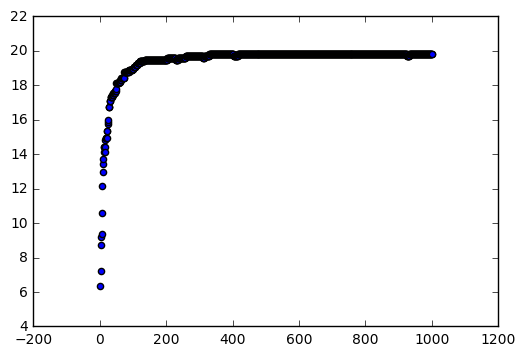

In [77]:
import csv
import numpy as np
import matplotlib.pyplot as plt

datapoints = []

#seqdist.txt will be of the form
#src_tree<tab>target_tree<tab>geo_distance
with open("seqdist.csv", 'r') as seqfile:
    seq_reader = csv.reader(seqfile,delimiter='\t')

    for row in seq_reader:
        datapoints.append([int(row[1]),float(row[2])])

#convert to numpy array
datapoints = np.array(datapoints)

plt.scatter(datapoints[:,0],datapoints[:,1])

plt.show()

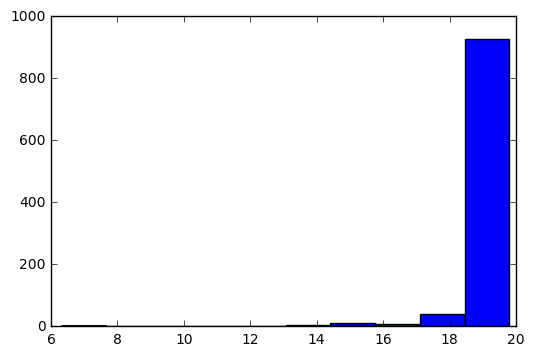

In [82]:
plt.hist(datapoints[:,1],bins=10)
plt.show()